# **MODELISATION 1ERE APPROCHE - MODEL FIRST APPROACH**

In [93]:
#We import the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Loading the data and showing the first 5 rows
dataset_path = '/content/sample_data/dataset_ms_ls.xlsx'
data = pd.read_excel(dataset_path)

data.head()

,Artistes,songs,url,id,image_path,Streamed/Non-Streamed,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Natalie Imbruglia,On My Way,https://www.youtube.com/watch?v=hhnBDkgLJPg,0DEJ9GEuWuGFMR1GhPORnY,On My Way.png,0,0.633,0.690,7,-4.397,1,0.0298,0.02460,0.000005,0.1310,0.631,103.003,4
1,OFFICIAL HIGE DANDISM,Pretender,https://www.youtube.com/watch?v=MbhyzQiRFXY,15HNdxGKNCIO9pgaY4n7FU,Pretender (歌詞) official髭男dism.png,1,0.538,0.869,8,-3.464,1,0.0275,0.04700,0.000000,0.1400,0.369,91.972,4
2,Bryan Adams,Summer Of '69,https://www.youtube.com/watch?v=eFjjO_lhf9c,0GONea6G2XdnHWjNZd6zt3,Summer Of 69.png,1,0.509,0.834,2,-6.205,1,0.0386,0.01830,0.000000,0.0732,0.774,139.130,4
3,Fuse ODG,What it do,https://www.youtube.com/watch?v=gTyLD5gHAbg,2V3mQTPHYkxbkYxXMjnKFA,What It Do.png,0,0.834,0.878,7,-3.369,1,0.1200,0.00313,0.149000,0.2460,0.315,102.043,4
4,Édith Piaf,La vie en rose,https://www.youtube.com/watch?v=rzeLynj1GYM,4FmiciU3ZmfgABlbCSXcWw,La Vie en rose.png,1,0.390,0.302,8,-8.687,1,0.0321,0.98400,0.000000,0.0871,0.422,82.520,4


In [12]:
def preprocessing(root_dir_path,image_file_name, desired_width, desired_height):

  #We open the image
  image = root_dir_path + image_file_name
  image = Image.open(image).convert('RGB')

  #We resize the iimage
  image = image.resize((desired_width, desired_height))

  #We convert the image to an numpy array
  image = np.array(image)

  #We normalize the image
  image = image/255.0

  return image

#In the dataset_ms_ls.xlsx file, we have a column with the images path of each song.
#Since the images in the different spectrogram path are not in the same order as the dataset_ms_ls,
#We have to make sure each line of dataset_ms_ls is attributed to the correct image
#For this sake, we have the next function
def images_from_dataset_path_1st_approach(dataset,hit_path,non_hit_path,spec_type='mel'):
  images = []
  if spec_type == 'mel':
    h = 224
    w = 224
  else:
    h = 256
    w = 512
  for i in range(len(dataset)):
    if dataset['Streamed/Non-Streamed'][i] == 1:
      images.append(preprocessing(hit_path,dataset['image_path'][i], w, h))
    else:
      images.append(preprocessing(non_hit_path,dataset['image_path'][i], w, h))
  return np.array(images)

In [13]:
#We start by shuffling the dataset to make sure the model doesnot learn to predict based on the index
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
#We drop the irrelevant columns for the random forest and create the target variable
X = data.drop(columns=['Artistes', 'songs', 'url', 'id', 'image_path', 'Streamed/Non-Streamed'])
y = data['Streamed/Non-Streamed']

**MEL SPECTROGRAM - FIRST APPROACH**

In [14]:
#The path of the mel spectrograms for streamed and non streamed
mel_spectrogram_hit_images_path_1st = '/content/drive/MyDrive/musics/mel-spectrograms hits/'
mel_spectrogram_non_hit_images_path_1st = '/content/drive/MyDrive/musics/mel-spectrograms non hits/'

In [15]:
#This numpy array of images is in the same order as data
#So for example data['acousticness'][i] is the same song as mel_images_1st_approach[i]
mel_images_1st_approach = images_from_dataset_path_1st_approach(data,mel_spectrogram_hit_images_path_1st,mel_spectrogram_non_hit_images_path_1st)

In [16]:
#This will be our callback function when the accuracy of the model will not change on 3 successives epochs
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

mel_model = Sequential([
    Conv2D(16, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    Dropout(0.25),
    Conv2D(32, (5, 5), activation='relu'),
    Conv2D(32, (5, 5), activation='relu'),
    Dropout(0.25),
    Conv2D(32, (70, 3), activation='relu'),
    Dropout(0.25),
    Conv2D(32, (70, 3), activation='relu'),
    Dropout(0.25),
    Conv2D(32, (70, 3), activation='relu'),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
mel_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle
mel_history = mel_model.fit(mel_images_1st_approach, y, epochs=15, batch_size=32, validation_split=0.20,
                            callbacks=[early_stopping])

Epoch 1/15
8/8 [==============================] - 60s 4s/step - loss: 1.0891 - accuracy: 0.5208 - val_loss: 0.6922 - val_accuracy: 0.5333
Epoch 2/15
8/8 [==============================] - 4s 558ms/step - loss: 0.7187 - accuracy: 0.5208 - val_loss: 0.6927 - val_accuracy: 0.5333
Epoch 3/15
8/8 [==============================] - 4s 536ms/step - loss: 0.6935 - accuracy: 0.4792 - val_loss: 0.6932 - val_accuracy: 0.4667
Epoch 4/15
8/8 [==============================] - 4s 532ms/step - loss: 0.6934 - accuracy: 0.4750 - val_loss: 0.6933 - val_accuracy: 0.4667
Epoch 4: early stopping


In [19]:
# We extract the information we get from the Dense(128, activation='relu') layer
mel_dense_output_model = Model(inputs=mel_model.input, outputs=mel_model.layers[-2].output)
mel_features = mel_dense_output_model.predict(mel_images_1st_approach)
print(mel_features.shape)

10/10 [==============================] - 4s 376ms/step
(300, 128)


In [28]:
#We create a dataframe with the mel features extracted
df_features_mel = pd.DataFrame(mel_features, columns=[f'feature_{i}' for i in range(mel_features.shape[1])])

**CQT SPECTROGRAM - FIRST APPROACH**

In [20]:
cqt_spectrogram_hit_images_path_1st = '/content/drive/MyDrive/musics/new_cqt hits/'
cqt_spectrogram_non_hit_images_path_1st = '/content/drive/MyDrive/musics/new_cqt non hits/'

In [21]:
cqt_images_1st_approach = images_from_dataset_path_1st_approach(data,cqt_spectrogram_hit_images_path_1st,cqt_spectrogram_non_hit_images_path_1st,'cqt')

In [22]:
cqt_model = Sequential([
    Conv2D(16, (5, 5), activation='relu', input_shape=(256, 512, 3)),
    Dropout(0.25),
    Conv2D(32, (5, 5), activation='relu'),
    Conv2D(32, (5, 5), activation='relu'),
    Dropout(0.25),
    Conv2D(32, (70, 3), activation='relu'),
    Dropout(0.25),
    Conv2D(32, (70, 3), activation='relu'),
    Dropout(0.25),
    Conv2D(32, (70, 3), activation='relu'),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Couche de sortie binaire pour "hit" ou "non hit"
])

# Compilation du modèle
cqt_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle
cqt_history = cqt_model.fit(cqt_images_1st_approach, y, epochs=15, batch_size=32, validation_split=0.20,
                            callbacks=[early_stopping])

Epoch 1/15
8/8 [==============================] - 193s 13s/step - loss: 27.3635 - accuracy: 0.4958 - val_loss: 0.6924 - val_accuracy: 0.5333
Epoch 2/15
8/8 [==============================] - 29s 4s/step - loss: 0.6931 - accuracy: 0.4958 - val_loss: 0.6925 - val_accuracy: 0.5333
Epoch 3/15
8/8 [==============================] - 29s 4s/step - loss: 0.6934 - accuracy: 0.4917 - val_loss: 0.6926 - val_accuracy: 0.5333
Epoch 4/15
8/8 [==============================] - 29s 4s/step - loss: 0.6933 - accuracy: 0.4917 - val_loss: 0.6927 - val_accuracy: 0.5333
Epoch 4: early stopping


In [24]:
# We extract the information we get from the Dense(128, activation='relu') layer
cqt_dense_output_model = Model(inputs=cqt_model.input, outputs=cqt_model.layers[-2].output)
cqt_features = cqt_dense_output_model.predict(cqt_images_1st_approach)
print(cqt_features.shape)

10/10 [==============================] - 17s 2s/step
(300, 128)


In [29]:
#We create a dataframe with the mel features extracted
df_features_cqt = pd.DataFrame(cqt_features, columns=[f'feature_{i}' for i in range(cqt_features.shape[1])])

**GRADIENT BOOSTING CLASSIFIER**

In [71]:
#We specify all the continuous vairables
X_continuous = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo']

In [72]:
#We specify all the categorical variables
X_categorical = ['key','mode','time_signature']

In [73]:
#We do a one hot encoding for all the categorical variables
df_one_hot = pd.get_dummies(data[X_categorical], drop_first=True)

In [74]:
#Combination of the new features with our dataset features
X = pd.concat([data[X_continuous], df_one_hot, df_features_mel,df_features_cqt], axis=1)

In [75]:
#We divide the data to have a train data and a validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
#Pipeline configuration
#In the pipeline, we will normalize the X. But it is not necessary since X features are normalized (only loudness, energy and tempo are not)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

#Parameter grid configuration
param_grid = {
    'gb__n_estimators': [100, 200, 300, 400],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7],
    'gb__min_samples_split': [2, 5, 10],
    'gb__min_samples_leaf': [1, 2, 4]
}

#Grid Search execution
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gb__learning_rate': [0.01, 0.1, 0.2],
                         'gb__max_depth': [3, 5, 7],
                         'gb__min_samples_leaf': [1, 2, 4],
                         'gb__min_samples_split': [2, 5, 10],
                         'gb__n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [99]:
# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test set (we kept the name of the test variable as X_val but it is for test)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_val)
best_report = classification_report(y_val, y_pred_best)

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Classification Report:\n", best_report)

Best Parameters: {'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 2, 'gb__n_estimators': 300}
Best Cross-Validation Score: 0.5875
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.57      0.59        30
           1       0.59      0.63      0.61        30

    accuracy                           0.60        60
   macro avg       0.60      0.60      0.60        60
weighted avg       0.60      0.60      0.60        60



In [100]:
#We show the importances of the features - Note that, unlike the features from dataset, the other features are abstract features we obtain with the cqt and mel model
features_gradient_boosting = X_train.columns
important_features = pd.DataFrame({'Feature': features_gradient_boosting, 'Importance': best_model['gb'].feature_importances_})
important_features = important_features.sort_values(by='Importance', ascending=False)

#We print the top 20 features
print(important_features[:40])

              Feature  Importance
64         feature_52    0.045517
90         feature_78    0.037963
51         feature_39    0.037651
120       feature_108    0.035192
100        feature_88    0.034686
22         feature_10    0.034244
40         feature_28    0.033518
4        acousticness    0.033375
73         feature_61    0.032687
88         feature_76    0.032667
122       feature_110    0.032090
19          feature_7    0.029546
9                 key    0.028862
84         feature_72    0.027194
7             valence    0.025301
6            liveness    0.022237
5    instrumentalness    0.021920
33         feature_21    0.021125
91         feature_79    0.019744
14          feature_2    0.018328
63         feature_51    0.018276
104        feature_92    0.017994
2            loudness    0.016662
102        feature_90    0.014916
60         feature_48    0.014436
123       feature_111    0.013576
121       feature_109    0.013556
27         feature_15    0.013219
31         fea

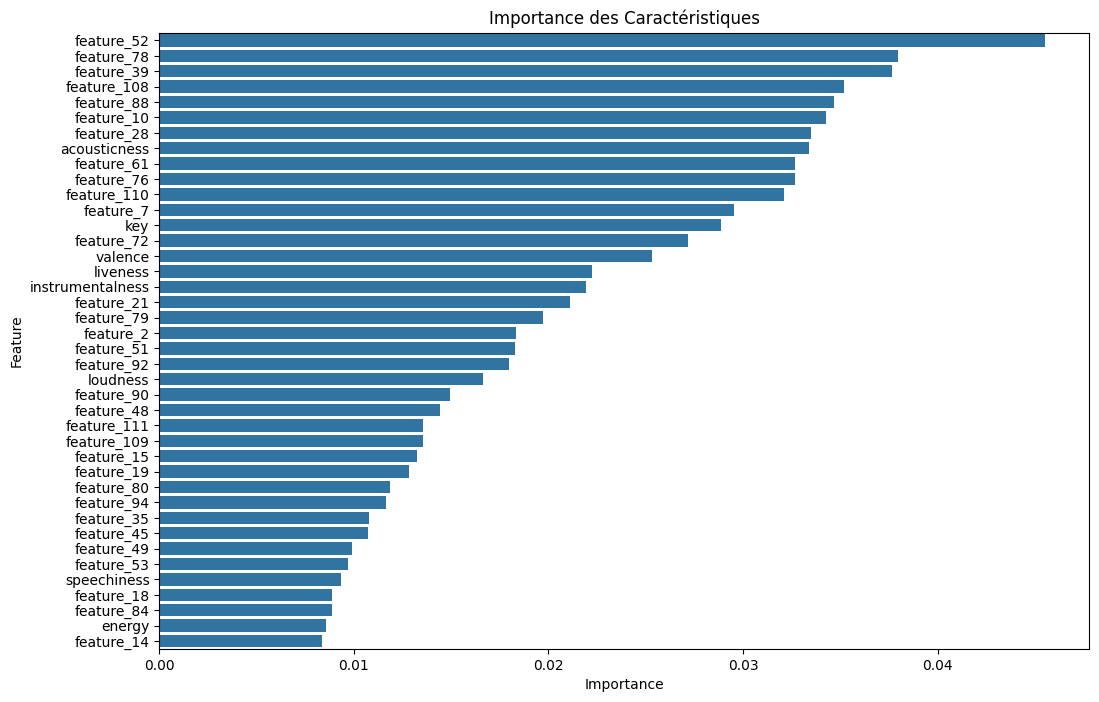

In [101]:
# Visualiser les importances des caractéristiques
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=important_features[:40])
plt.title('Importance des Caractéristiques')
plt.show()

On peut remarquer que le modèle a su créer 7 features abstraites qui sont plus impactantes que la feature "acousticness".
Dans les 40 premières features importantes, on remarque qu'il n'y a pas le "mode", ce qui peut être surprenant. Cependant , la valence fait partie des features importantes.  /  We can see that the model has created 7 abstract features that are more impactful than the “acousticness” feature.
In the first 40 important features, we notice that “mode” is missing, which may be surprising. However, valence is one of the most important features.

In [102]:
#We compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_best)

#We compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_best)
roc_auc = roc_auc_score(y_val, y_pred_best)

Text(120.72222222222221, 0.5, 'Actual')

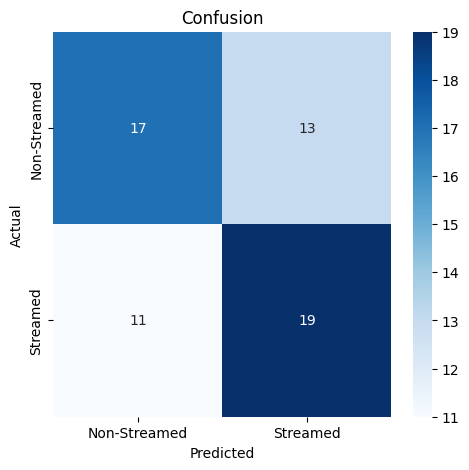

In [107]:
# Confusion matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Streamed', 'Streamed'],
            yticklabels=['Non-Streamed', 'Streamed'])
plt.title('Confusion')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Sur les données qui ont servi de test (60), on remarque que :                  

*   True Positive : Le modèle a correctement prédit 19 sons streamés / The model correctly predicted 19 streamed sounds


*   True Negative : Le modèle a correctement prédit 17 sons non-streamés  / The model correctly predicted 17 non-streamed sounds


*   False Negative : 13 sons non streamés ont été classés comme streamés / 13 unstreamed sounds were classified as streamed


*   False Positive : 11 sons streamés ont été classés comme non-streamés  / 11 streamed sounds were classified as non-streamed


Ceci nous donne effectivement une accuracy de 60% : (17+19)/(17+19+13+11)
Le modèle prédit correctement plus d'échantillons que ce qui serait attendu par une prédiction aléatoire.
Ca reste améliorable (en ajoutant des données et optimisant encore plus le modèle)

This effectively gives us an accuracy of 60%: (17+19)/(17+19+13+11)
The model correctly predicts more samples than would be expected from a random prediction.
There's still room for improvement (by adding more data and further optimizing the model).



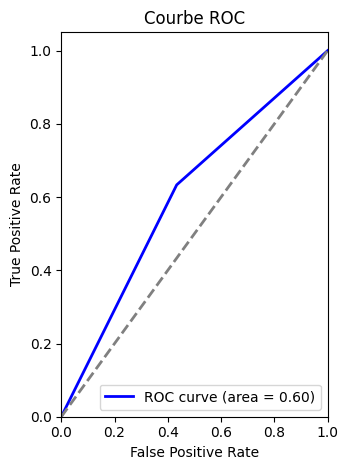

In [108]:
# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

On peut dire à partir de cette courbe ROC que le modèle a quand un même un faible pouvoir de discrimination mais il reste meilleur que le hasard.  / From this ROC curve, we can say that the model still has low discriminatory power, but is still better than chance.

# **INTERPRETATION**

Comme on a pu le constater, la précision des deux modèles convolutifs était très basse. Ceci peut-être dû à plusieurs facteurs :  la très faible quantité de données, ou la difficulté d'interpétation des features pour le modèle, ou même l'absence de caractéristiques discriminatives dans les spectrogrammes. Il faudrait dans un premier temps augmenter la quantité de données pour être vraiment fixé. Malheureusement, ceci réprésente un temps colossal. C'est une piste à explorer dans le futur.

Cependant, les deux modèles nous ont permis d'extraire des features abstraites : 128 features abstraites pour chacun des spectrogrammes (MEL et CQT).
On a ainsi pu combiner ces nouvelles features aux 12 autres features qu'on avait grâce à l'API de spotify, les 12 features qui sont dans le fichier dataset_msèls.xlsx.

Avant la concaténation des 3 Dataframes (celle de la Mel, CQT, et Dataset_ms_ls), on avait vu qu'on atteignait un modèle avec une accuracy de 53% avec une Random Forest (avec des paramètres optimaux).

Après la fusion de toutes les dataframes, qui réprésente indirectement l'ajout de nouvelles features (abstraites), on a un modèle avec une précision de 60% sur les données d'entrainement.              


----------------------------------------------------------------
As can be seen, the accuracy of both convolutional models was very low. This may be due to a number of factors: the very small amount of data, or the difficulty of interpetating features for the model, or even the absence of discriminative features in the spectrograms. The first step would be to increase the amount of data to be sure. Unfortunately, this would take an enormous amount of time. This is an avenue to be explored in the future.

However, both models enabled us to extract abstract features: 128 abstract features for each of the spectrograms (MEL and CQT).
We were then able to combine these new features with the 12 other features we had thanks to the spotify API, the 12 features in the dataset_msèls.xlsx file.

Before concatenating the 3 dataframes (Mel's, CQT, and Dataset_ms_ls), we had seen that we had reached a model with an accuracy of 53% with a Random Forest (with optimal parameters).

After merging all the dataframes, which indirectly represents the addition of new (abstract) features, we have a model with an accuracy of 60% on the training data.


